### Set Parameters

In [1]:
pf_id = 2 #problem formulation id; should match file name
n_scenarios = pow(2, 10) # Ideally a power of 2 > 1000 ... 2^10 = 1024

### Run Model for Open Exploration

##### Define a nothing policy (necessary for the code to run)

In [2]:
# don't @ me it has to be set up this way to work
# from ema_workbench import Policy
# policies = [Policy('policy 0', **{'0_RfR 0':0,
#                                   '0_RfR 1':0,
#                                   '0_RfR 2':0,
#                                   'A.1_DikeIncrease 0':0,
#                                   'A.1_DikeIncrease 1':0,
#                                   'A.1_DikeIncrease 2':0,
#                                   '1_RfR 0':0,
#                                   '1_RfR 1':0,
#                                   '1_RfR 2':0,
#                                   'A.2_DikeIncrease 0':0,
#                                   'A.2_DikeIncrease 1':0,
#                                   'A.2_DikeIncrease 2':0,
#                                   '2_RfR 0':0,
#                                   '2_RfR 1':0,
#                                   '2_RfR 2':0,
#                                   'A.3_DikeIncrease 0':0,
#                                   'A.3_DikeIncrease 1':0,
#                                   'A.3_DikeIncrease 2':0,
#                                   '3_RfR 0':0,
#                                   '3_RfR 1':0,
#                                   '3_RfR 2':0,
#                                   'A.4_DikeIncrease 0':0,
#                                   'A.4_DikeIncrease 1':0,
#                                   'A.4_DikeIncrease 2':0,
#                                   '4_RfR 0':0,
#                                   '4_RfR 1':0,
#                                   '4_RfR 2':0,
#                                   'A.5_DikeIncrease 0':0,
#                                   'A.5_DikeIncrease 1':0,
#                                   'A.5_DikeIncrease 2':0,
#                                   'EWS_DaysToThreat':0
#                                   })]

##### Import packages


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Import things and set up model (with the selected problem formulation)


In [4]:
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(pf_id) #changes for each file

def get_do_nothing_policies(l_bol = 0, policy_id = 0):
    return [Policy('policy %s'%policy_id, **{l.name:l_bol for l in dike_model.levers})]

policies = get_do_nothing_policies()

##### Define uncertainties and levers

In [5]:
import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

##### Run the model with the defined number of scenarios and the nothing policy

In [6]:
from ema_workbench import (ema_logging, MultiprocessingEvaluator, Samplers)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 40960 scenarios * 1 policies * 1 model(s) = 40960 experiments
100%|██████████████████████████████████| 40960/40960 [4:50:53<00:00,  2.35it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


##### Define experiments and outcome; print names of the outcomes

In [7]:
experiments, outcomes = results
print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


### Save Results

In [8]:
from ema_workbench import save_results

save_results(results, './output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)

[MainProcess/INFO] results saved successfully to C:\Users\python\Documents\GitHub\MBDM\final assignment\output\open_exploration\Open_Exploration_id_2.tar.gz


In [9]:
experiments.to_csv('./output/open_exploration/Open_Exploration_id_%s_exp.csv'%pf_id, index=False)
pd.DataFrame.from_dict(outcomes).to_csv('./output/open_exploration/Open_Exploration_id_%s_out.csv'%pf_id, index=False)

### Visualization

##### Import stuff

In [10]:
from ema_workbench.analysis import prim, dimensional_stacking, feature_scoring
from ema_workbench import load_results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

##### Load in previously saved results; can visualize without rerunning the whole notebook

In [32]:
try:
    results = load_results('./output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)
except NameError as e:
    if (str(e) == "name 'pf_id' is not defined"):
        pf_id = 2
        print(e)
        print("defaulting to pf_id = %s"%pf_id)
        results = load_results('./output/open_exploration/Open_Exploration_id_%s.tar.gz'%pf_id)
    else:
        raise(e)
experiments, outcomes = results

[MainProcess/INFO] results loaded successfully from C:\Users\python\Documents\GitHub\MBDM\final assignment\output\open_exploration\Open_Exploration_id_2.tar.gz


##### As a failsafe, drop NaN outcomes by converting to pandas DataFrame

In [34]:
outcomes_pd = pd.DataFrame.from_dict(outcomes)
outcomes_pd.dropna(inplace=True)

##### Convert outcomes back into array dict

In [35]:
outcomes_nonan = outcomes_pd.to_dict('list')

for outcome in outcomes_nonan.keys():
    outcomes_nonan[outcome] = np.array(outcomes_nonan[outcome])

outcomes = outcomes_nonan

##### Drop corresponding runs from experiments

In [36]:
experiments.drop(list(set(experiments.index) - set(outcomes_pd.index)), inplace=True)

## Subspace Partitioning

This is where the names of each outcome will need to be fed into the visualizations to get reasonable outputs, ignore this for now or change the names yourself.

#### Outcome: Expected Annual Damage

##### Define x, y, and threshold

In [37]:
x = experiments
data = outcomes["Expected Annual Damage"]
y = data < np.percentile(data, 10) #np.quantile(data, .5)
#data <  np.percentile(data, 10) # not sure how this work, gives better density coverage results?
#quantile

##### Tradeoff density and coverage

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40960 points remaining, containing 4096 cases of interest
[MainProcess/INFO] mean: 0.9580064605445316, mass: 0.0529052734375, coverage: 0.5068359375, density: 0.9580064605445316 restricted_dimensions: 7


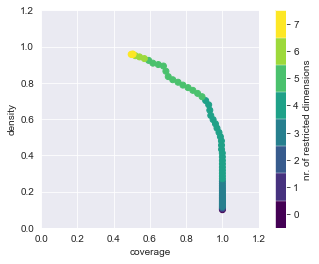

In [16]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

In [17]:
print(box1.peeling_trajectory)

    coverage   density  id      mass      mean  res_dim
0   1.000000  0.100000   0  1.000000  0.100000        0
1   1.000000  0.105350   1  0.949219  0.105350        1
2   1.000000  0.110985   2  0.901025  0.110985        2
3   1.000000  0.116882   3  0.855566  0.116882        3
4   1.000000  0.123136   4  0.812109  0.123136        3
5   1.000000  0.129768   5  0.770605  0.129768        3
6   1.000000  0.136675   6  0.731665  0.136675        3
7   1.000000  0.144063   7  0.694141  0.144063        3
8   1.000000  0.151844   8  0.658569  0.151844        3
9   1.000000  0.160025   9  0.624902  0.160025        3
10  1.000000  0.168657  10  0.592920  0.168657        3
11  1.000000  0.177570  11  0.563159  0.177570        3
12  1.000000  0.187049  12  0.534619  0.187049        3
13  1.000000  0.197245  13  0.506982  0.197245        3
14  1.000000  0.208024  14  0.480713  0.208024        3
15  1.000000  0.219401  15  0.455786  0.219401        3
16  1.000000  0.231386  16  0.432178  0.231386  

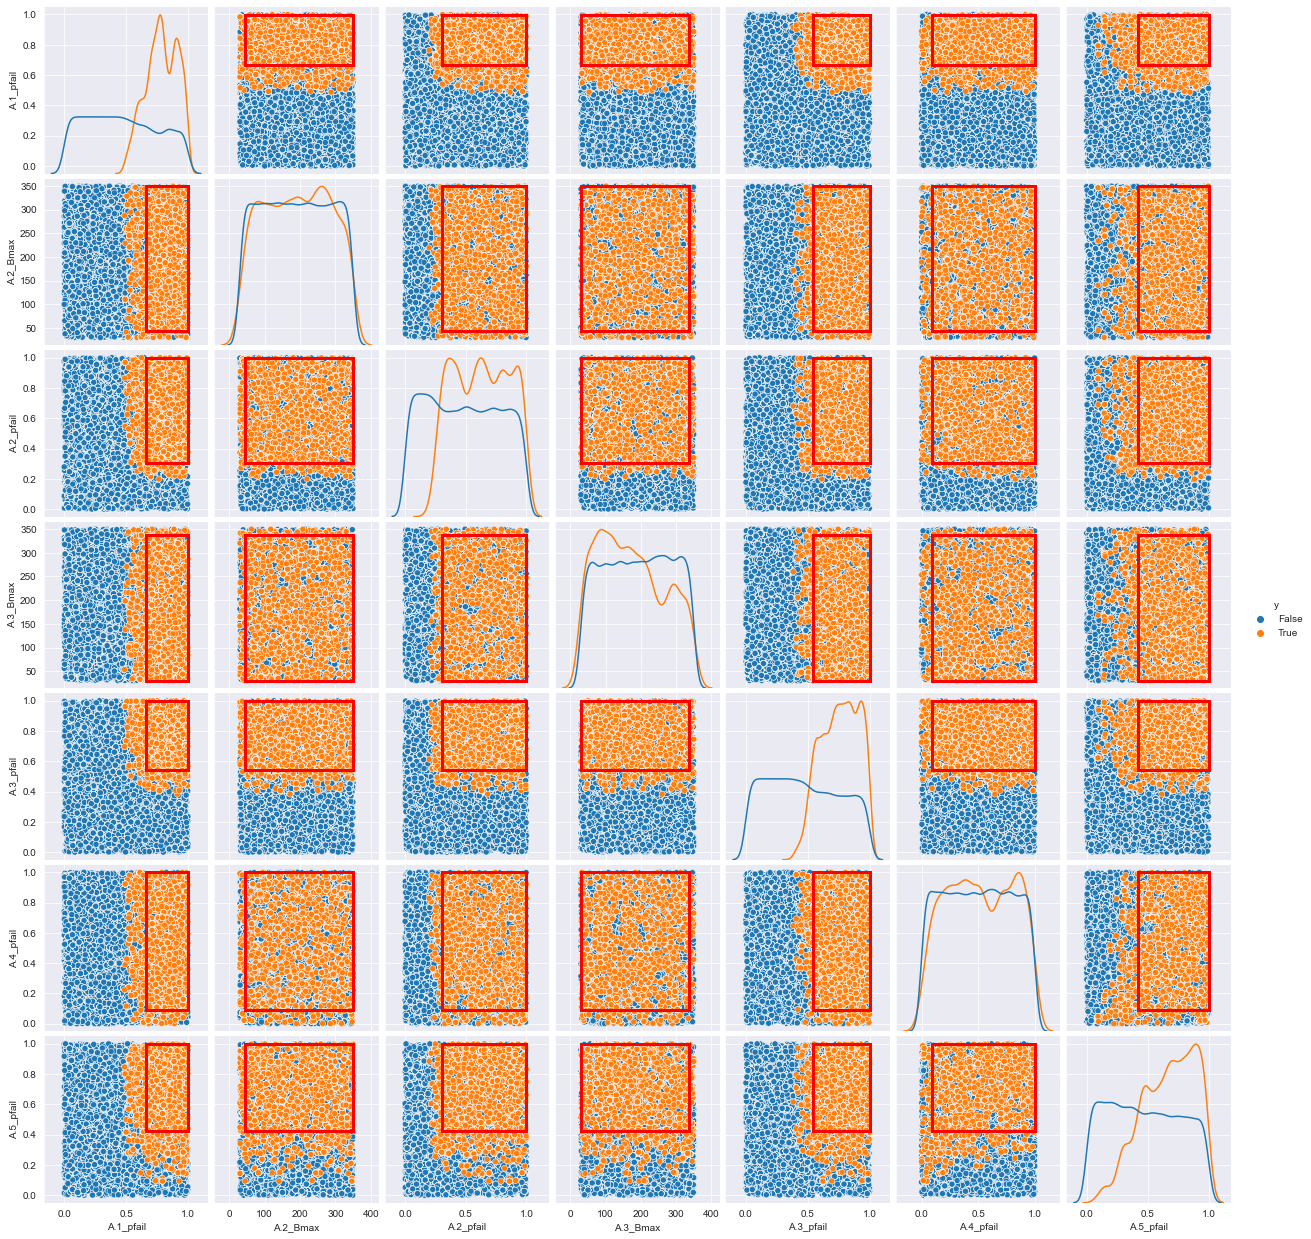

In [18]:
box1.show_pairs_scatter()
plt.show()

In [19]:
box1.prim.y
box1.prim.x.iloc[box1.yi_initial, :]

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,150.46875,1.5,0.486816,208.28125,10.0,0.241699,217.96875,10.0,0.671387,...,0,0,0,0,0,0,0,0,0,0
1,46,150.46875,1.5,0.486816,208.28125,10.0,0.241699,217.96875,10.0,0.671387,...,0,0,0,0,0,0,0,0,0,0
2,0,197.96875,1.5,0.486816,208.28125,10.0,0.241699,217.96875,10.0,0.671387,...,0,0,0,0,0,0,0,0,0,0
3,0,150.46875,1.0,0.486816,208.28125,10.0,0.241699,217.96875,10.0,0.671387,...,0,0,0,0,0,0,0,0,0,0
4,0,150.46875,1.5,0.825684,208.28125,10.0,0.241699,217.96875,10.0,0.671387,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,4,144.53125,1.0,0.094238,253.28125,10.0,0.319824,111.09375,1.0,0.530762,...,0,0,0,0,0,0,0,0,0,0
40956,4,144.53125,1.0,0.094238,253.28125,10.0,0.319824,111.09375,1.0,0.530762,...,0,0,0,0,0,0,0,0,0,0
40957,4,144.53125,1.0,0.094238,253.28125,10.0,0.319824,111.09375,1.0,0.530762,...,0,0,0,0,0,0,0,0,0,0
40958,4,144.53125,1.0,0.094238,253.28125,10.0,0.319824,111.09375,1.0,0.530762,...,0,0,0,0,0,0,0,0,0,0


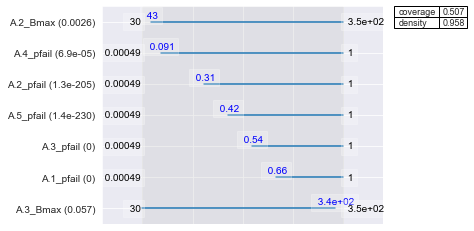

In [20]:
box1.inspect(style='graph')
plt.show()

##### Dimensional stacking

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


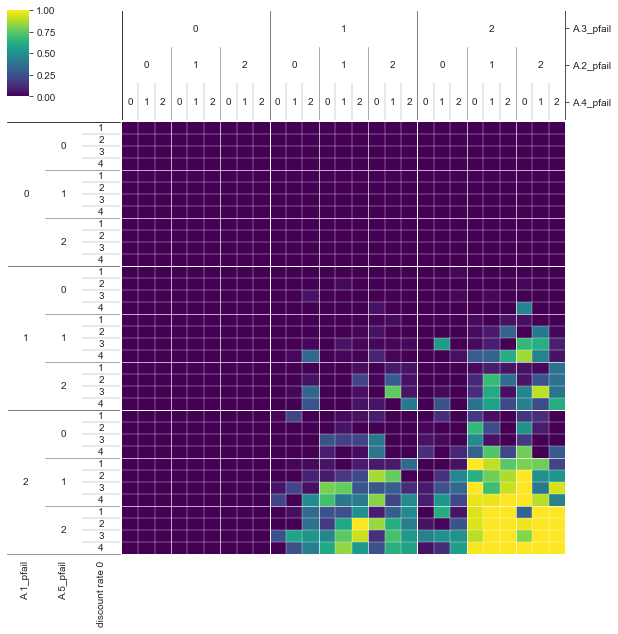

In [21]:
dimensional_stacking.create_pivot_plot(x, y) # 2, nbins=3
plt.show()

##### What this means for us
Scenarios of interest for creating high(?) annual damage are scenarios with high values for:
    A1-5 Pfail and discount rate 0

This may change after running with SOBOL and more scenarios

Also not entierly sure how to pull values for this since the pfail is only supposed to range between 0 and 1 and discount rate is between 1.5 and 4.5

#### Outcome: Expected Number of Deaths

##### Define x, y, and threshold

In [41]:
x = experiments
data = outcomes["Expected Number of Deaths"]
y = data < np.percentile(data, 10) #np.quantile(data, .5) # 10 percent of worst outcomes

##### Tradeoff density and coverage

[MainProcess/INFO] mean: 0.9548235294117647, mass: 0.0518798828125, coverage: 0.4964521654024957, density: 0.9548235294117647 restricted_dimensions: 7


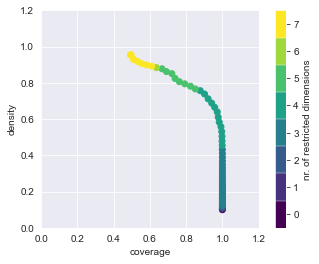

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 40960 points remaining, containing 4087 cases of interest
[MainProcess/INFO] mean: 0.9548235294117647, mass: 0.0518798828125, coverage: 0.4964521654024957, density: 0.9548235294117647 restricted_dimensions: 7


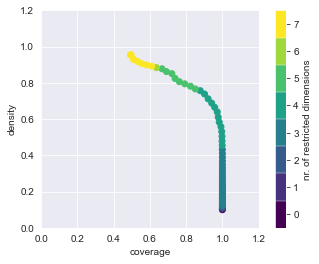

In [43]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()
box1.show_tradeoff()
plt.show()

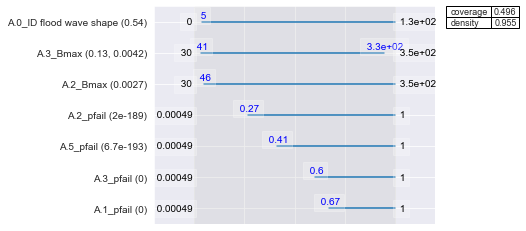

In [46]:
box1.inspect(style='graph')
plt.show()

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


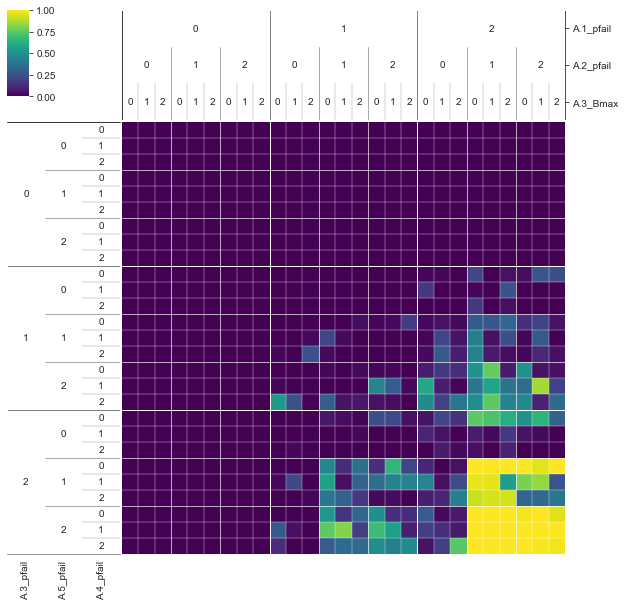

In [47]:
dimensional_stacking.create_pivot_plot(x, y) # 2, nbins=3
plt.show()

### Sensitivity Analysis

### Feature Scoring

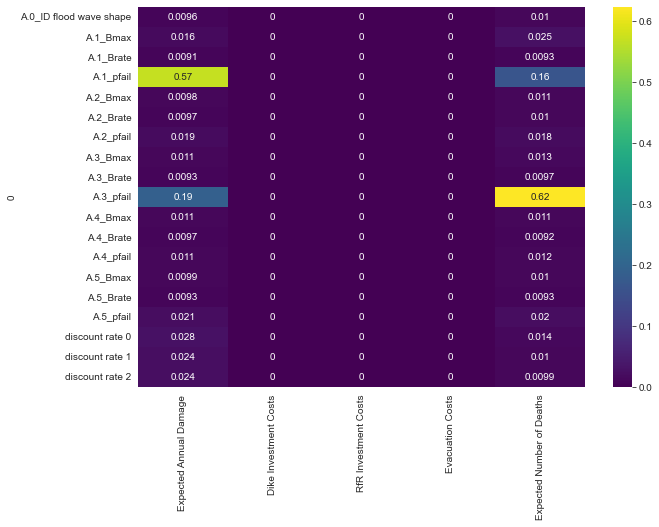

In [24]:
x = experiments.loc[:,['A.0_ID flood wave shape', 'A.1_pfail', 'A.2_pfail', 'A.3_pfail', 'A.4_pfail', 'A.5_pfail', 'A.1_Bmax', 'A.2_Bmax', 'A.3_Bmax', 'A.4_Bmax', 'A.5_Bmax',  'A.1_Brate', 'A.2_Brate', 'A.3_Brate', 'A.4_Brate', 'A.5_Brate', 'discount rate 0', 'discount rate 1', 'discount rate 2']]
y = outcomes

plt.figure(figsize = (10,7))

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, )

plt.show()

In [1]:
n_scenarios = pow(2, 10) # Ideally a power of 2 > 1000 ... 2^10 = 1024
policies = 1
pf_id = 2

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from ema_workbench.util import ema_logging
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import Policy

ema_logging.log_to_stderr(ema_logging.INFO)

dike_model, planning_steps = get_model_for_problem_formulation(pf_id) #changes for each file

In [3]:
import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

In [4]:
from ema_workbench import (ema_logging, MultiprocessingEvaluator, Samplers)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies, uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 320 scenarios * 50 policies * 1 model(s) = 16000 experiments
100%|██████████████████████████████████| 16000/16000 [1:45:47<00:00,  2.52it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [6]:
experiments, outcomes = results

In [10]:
from ema_workbench import save_results

save_results(results, './output/open_exploration/Open_Exploration_policies_id_%s.tar.gz' % pf_id)
experiments.to_csv('./output/open_exploration/Open_Exploration_policies_id_%s_exp.csv' % pf_id, index=False)
pd.DataFrame.from_dict(outcomes).to_csv('./output/open_exploration/Open_Exploration_policies_id_%s_out.csv' % pf_id, index=False)

[MainProcess/INFO] results saved successfully to C:\Users\python\Documents\GitHub\MBDM\final assignment\output\open_exploration\Open_Exploration_policies_id_2.tar.gz


In [16]:
outcomes

{'Expected Annual Damage': array([     0.        ,      0.        ,      0.        , ...,
        864785.02164951, 864785.02164951, 864785.02164951]),
 'Dike Investment Costs': array([8.47412731e+08, 8.47412731e+08, 8.47412731e+08, ...,
        5.23725548e+08, 5.23725548e+08, 5.23725548e+08]),
 'RfR Investment Costs': array([1.292e+09, 1.292e+09, 1.292e+09, ..., 6.542e+08, 6.542e+08,
        6.542e+08]),
 'Evacuation Costs': array([ 0.        ,  0.        ,  0.        , ..., 40.72778052,
        40.72778052, 40.72778052]),
 'Expected Number of Deaths': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.60936574e-05, 7.60936574e-05, 7.60936574e-05])}

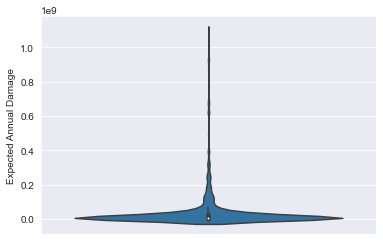

In [11]:
import pandas as pd
import seaborn as sns
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Expected Annual Damage')
plt.show()

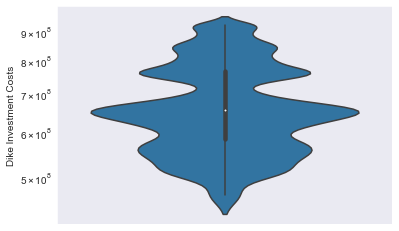

In [12]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Dike Investment Costs')
ax.set_yscale('log')
plt.show()

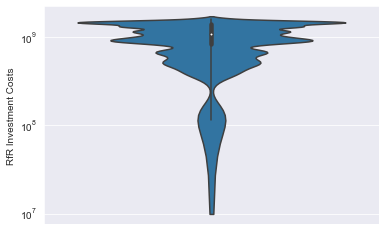

In [13]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='RfR Investment Costs')
ax.set_yscale('log')
plt.show()

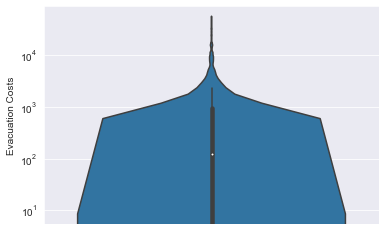

In [14]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Evacuation Costs')
ax.set_yscale('log')
plt.show()

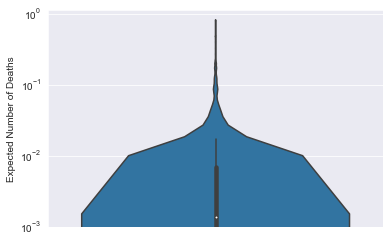

In [15]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()